In [37]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob #helps get file path
import pandas as pd
import numpy as np

In [38]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dnyap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load Model

In [39]:
#for zero shot classifier
model_name="facebook/bart-large-mnli"
device= 0 if torch.cuda.is_available() else 'cpu'

In [40]:
def load_model(device):
    theme_classifier=pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [41]:
theme_classifier=load_model(device)

Device set to use cpu


In [42]:
theme_list=["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [43]:
theme_classifier(
    "I gave him a right hook then left a jab",
    theme_list,
    multi_label=True
)

{'sequence': 'I gave him a right hook then left a jab',
 'labels': ['battle',
  'self development',
  'dialogue',
  'sacrifice',
  'hope',
  'betrayal',
  'friendship',
  'love'],
 'scores': [0.9134172201156616,
  0.6500979661941528,
  0.0765356719493866,
  0.07157518714666367,
  0.05478579178452492,
  0.03556474298238754,
  0.004386287648230791,
  0.0038914154283702374]}

Load Dataset

In [44]:
# using * all the files from subtitles ends with .ass as subtitles files end with ass
files=glob('../data/Subtitles/*.ass')

In [45]:
files[:5]

['../data/Subtitles\\Naruto Season 1 - 01.ass',
 '../data/Subtitles\\Naruto Season 1 - 02.ass',
 '../data/Subtitles\\Naruto Season 1 - 03.ass',
 '../data/Subtitles\\Naruto Season 1 - 04.ass',
 '../data/Subtitles\\Naruto Season 1 - 05.ass']

In [46]:
with open(files[0],'r') as file:
    lines=file.readlines()
    lines=lines[27:] # metadata is upto 27th line
    #here we are removing first nine commas to get the subtitle and then we are joining list of sentences by comma
    lines=[",".join(line.split(',')[9:]) for line in lines]
    

In [47]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [48]:
#replacing //n in subtitle format with a space
lines=[ line.replace('\\N','' ) for line in lines]

In [49]:
lines[:2]

['A long time ago, a powerful demon foxappeared with nine tails.\n',
 'With its powerful tails,\n']

In [50]:
#combining diff sentences in one big para
" ".join(lines[:10])

"A long time ago, a powerful demon foxappeared with nine tails.\n With its powerful tails,\n it could smash mountainsand create tidal waves.\n A band of Ninjas rose todefend their village from attack.\n We have to wait untilthe Fourth Hokage gets here!\n We can't let it get any closerto our village!\n One great Ninja was able toimprison the monster,\n but died in the process.\n This Ninja was known asâ€¦the Fourth Hokage.\n Naruto!\n"

In [51]:
# this text is now given to feed forward to  neural network which is zero shot classifier(theme classifer)
#we canot feed entire sub so we are sending them in batches
# and extracting epi no from file path
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [52]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths=glob(dataset_path+'/*.ass')
    scripts=[]
    episode_num=[]


    for path in subtitles_paths:
        #read lines
        with open(path,'r',encoding="utf8") as file:
            lines=file.readlines()
            lines=lines[27:] # metadata is upto 27th line
            #here we are removing first nine commas to get the subtitle and then we are joining list of sentences by comma
            lines=[",".join(line.split(',')[9:]) for line in lines]


        #replacing //n in subtitle format with a space
        lines=[ line.replace('\\N','' ) for line in lines]
        script=" ".join(lines)

        #get episode no
        episode=int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)


    #putting everything pandas dataframe
    df=pd.DataFrame.from_dict({"episode":episode_num,"script":scripts})
    return df
            

In [53]:
dataset_path="../data/Subtitles"
df=load_subtitles_dataset(dataset_path)

In [54]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon foxappeared ..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


Running Model

In [55]:
script=df.iloc[0]['script']
script

'A long time ago, a powerful demon foxappeared with nine tails.\n With its powerful tails,\n it could smash mountainsand create tidal waves.\n A band of Ninjas rose todefend their village from attack.\n We have to wait untilthe Fourth Hokage gets here!\n We can\'t let it get any closerto our village!\n One great Ninja was able toimprison the monster,\n but died in the process.\n This Ninja was known as…the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you!Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed ontothe Mountainside Images…\n And he vandalized andgraffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here,lruka Sensei?\n The question is what are you doing herewhen you should be in class 

In [56]:
#above long script is divided into multiple sentences so that it can fit in nlp token maximum
script_sentences=sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon foxappeared with nine tails.',
 'With its powerful tails,\n it could smash mountainsand create tidal waves.',
 'A band of Ninjas rose todefend their village from attack.']

In [57]:
#putting sentences in batches of 20
sentence_batch_size=20
script_batches=[]
for index in range(0,len(script_sentences),sentence_batch_size):
    sent=" ".join(script_sentences[index:index+sentence_batch_size]) 
    script_batches.append(sent)

    


In [58]:
script_batches[:3]

["A long time ago, a powerful demon foxappeared with nine tails. With its powerful tails,\n it could smash mountainsand create tidal waves. A band of Ninjas rose todefend their village from attack. We have to wait untilthe Fourth Hokage gets here! We can't let it get any closerto our village! One great Ninja was able toimprison the monster,\n but died in the process. This Ninja was known as…the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you!Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again? Yes.",
 'He climbed ontothe Mountainside Images…\n And he vandalized andgraffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here,lruka Sensei? The question is what are you doing herewhen you should be in class now? Now listen, Naruto. You failed the last grad

In [59]:
theme_output=theme_classifier(
    script_batches[:3],
    theme_list,
    multi_label=True
)

In [60]:
theme_output #classification if the frst 2 batches

[{'sequence': "A long time ago, a powerful demon foxappeared with nine tails. With its powerful tails,\n it could smash mountainsand create tidal waves. A band of Ninjas rose todefend their village from attack. We have to wait untilthe Fourth Hokage gets here! We can't let it get any closerto our village! One great Ninja was able toimprison the monster,\n but died in the process. This Ninja was known as…the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you!Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again? Yes.",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'self development',
   'sacrifice',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9732495546340942,
   0.9437205791473389,
   0.8486975431442261,
   0.7226595282554626,
   0.69957435131073,
   0.15611547231674194,
 

In [61]:
#wrangle output
themes={}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label]=[]
        themes[label].append(score)


In [62]:
themes

{'dialogue': [0.9732495546340942, 0.9010846018791199, 0.9813957214355469],
 'betrayal': [0.9437205791473389, 0.31804245710372925, 0.9394775629043579],
 'battle': [0.8486975431442261, 0.5074158310890198, 0.8250389695167542],
 'self development': [0.7226595282554626,
  0.7813712954521179,
  0.8824071884155273],
 'sacrifice': [0.69957435131073, 0.4107038676738739, 0.811819314956665],
 'hope': [0.15611547231674194, 0.12174125015735626, 0.6895676851272583],
 'friendship': [0.0511309914290905, 0.07042007893323898, 0.38587716221809387],
 'love': [0.04421435296535492, 0.014753744937479496, 0.27038586139678955]}

In [63]:
def get_themes_inference(script):
    script_sentences=sent_tokenize(script)

    #batch sentence
    sentence_batch_size=20
    script_batches=[]
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent=" ".join(script_sentences[index:index+sentence_batch_size]) 
        script_batches.append(sent)

    #run the model
    theme_output=theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
        )
    
    #wrangle output 
    themes={}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label]=[]
            themes[label].append(score)

    themes={key:np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [64]:
df=df.head(2)

In [65]:
df

,episode,script
0,1,"A long time ago, a powerful demon foxappeared ..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [66]:
output_themes=df['script'].apply(get_themes_inference)

In [67]:
output_themes

0    {'dialogue': 0.9371670782566071, 'betrayal': 0...
1    {'dialogue': 0.9740357100963593, 'sacrifice': ...
Name: script, dtype: object

In [68]:
#converting output to structured dataset
theme_df=pd.DataFrame(output_themes.to_list())

In [69]:
theme_df

,dialogue,betrayal,battle,self development,sacrifice,hope,friendship,love
0,0.937167,0.630882,0.678057,0.752015,0.555139,0.138928,0.060776,0.029484
1,0.974036,0.542820,0.679987,0.435066,0.666392,0.147580,0.055368,0.134843


In [70]:
df[theme_df.columns]=theme_df
df

,episode,script,dialogue,betrayal,battle,self development,sacrifice,hope,friendship,love
0,1,"A long time ago, a powerful demon foxappeared ...",0.937167,0.630882,0.678057,0.752015,0.555139,0.138928,0.060776,0.029484
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.974036,0.542820,0.679987,0.435066,0.666392,0.147580,0.055368,0.134843


Visualize Output


In [71]:
df=df.drop('dialogue',axis=1)

In [74]:
theme_output=df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns=['theme','score']
theme_output

,theme,score
0,betrayal,1.173702
1,battle,1.358044
2,self development,1.187082
3,sacrifice,1.221531
4,hope,0.286509
5,friendship,0.116144
6,love,0.164327


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns


AttributeError: Text.set() got an unexpected keyword argument 'rotations'

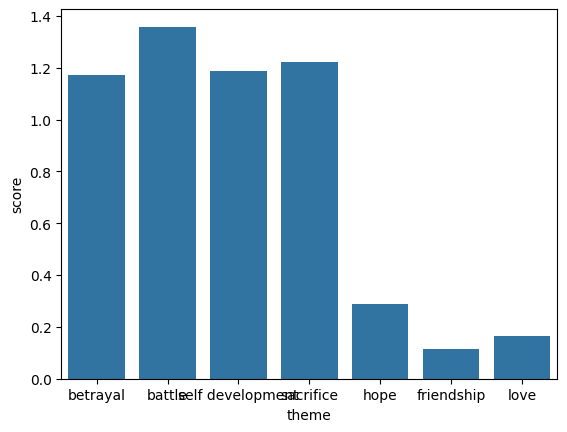

In [79]:
sns.barplot(data=theme_output, x="theme",y="score")
plt.xticks(rotations=45)
plt.show()